# Code for nomination peptide generation

In [1]:
import pandas as pd
import os
import numpy as np
import torch
import argparse

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from analysis import screen_routine
from dataset import SequenceDataset
from utils import hamming_distance

/nas/longleaf/home/dieckhau/miniconda3/envs/proteinMPNN/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Shared functions used by multiple runs

In [3]:
def hamming(args, library, pred_list):
    """Filter library based on hamming cutoff"""
    if args.hamming > 0:
        ref = SequenceDataset(sele=args.sele, anti=args.anti, features=args.features, variable_region=args.variable_region)
        tr_peps = ref.df.var_seq.values.astype('str')
        tr_peps = np.array([list(word) for word in tr_peps])
        flag, min_H, closest = [], [], []
        library = np.array([list(word) for word in library])
        for pep in tqdm(library):
            distances = hamming_distance(P=tr_peps, pep=pep, return_distance=True)
            min_dist = np.min(distances)
            flag.append(min_dist > args.hamming)
            min_H.append(min_dist)
            sim_seq = tr_peps[np.argmin(distances), :]
            closest.append(sim_seq)
        
        # library = np.array([list(word) for word in library])
        library = library[flag, :]
        pred_list = torch.tensor(pred_list).detach().numpy()[flag]
        min_H = np.array(min_H)[flag]
        closest = np.array(closest)[flag]
    
        library = np.array([''.join(l) for l in library])
        closest = np.array([''.join(l) for l in closest])
        df = pd.DataFrame({
            'SEQ': library, 
            'MODEL_SCORE': pred_list, 
            'MIN_HAMMING_DIST': min_H, 
            'MOST_SIMILAR_TRAINING_SEQ': closest
        })
    
        print('%s peptides passed Hamming cutoff' % str(df.shape[0]))
        return df, ref
    else:
        ref = SequenceDataset(sele=args.sele, anti=args.anti, features=args.features, variable_region=args.variable_region)
        return ref

def y_star_score(sel_df, anti_df):
    """Calculate Y-star scores for a sele/anti dataset"""
    
    def y_star_single(sel_df, anti_df, p, aa):
        alphabet = 'ACDEFGHIKLMNPQRSTVWY'
        f_sel = sel_df.loc[sel_df['var_seq'].str[p] == alphabet[aa]]['count'].sum() / sel_df['count'].sum()
        f_anti = anti_df.loc[anti_df['var_seq'].str[p] == alphabet[aa]]['count'].sum() / anti_df['count'].sum()
        return float(f_sel) / float(f_anti)

    seqs = sel_df['var_seq'].values
    pos_idx = len(seqs[0])
    aa_idx = 20
    y_star = np.zeros((pos_idx, aa_idx), dtype=np.float32)
    for p in tqdm(range(pos_idx)):
        for aa in range(aa_idx):
            y_star[p, aa] = y_star_single(sel_df, anti_df, p, aa)
    return y_star

def s_score(df, y_star):
    """Calculate S Score for a df of seqs"""
    alphabet = 'ACDEFGHIKLMNPQRSTVWY'
    y_star = np.log2(y_star)
    seqs = df['var_seq']
    s_scores = []
    for s in tqdm(seqs):
        y_list = []
        flag = True
        for idx, aa in enumerate(s):
            try:
                y = y_star[idx, alphabet.index(aa)]
                y_list.append(y)
            except ValueError:
                flag = False
                break
        if flag:
            s_scores.append(np.sum(y_list))
    return s_scores


# Peptide set filtering functions

In [ ]:
def select_2Cys(library, pred_list):
    """Filter library to only include those with 2 Cys (also remove problematic residues, KR"""
    seqs = [''.join(l) for l in library]
    # seq_filter = [(s[4:].count('C') == 2 and s.count('K') < 1 and s.count('R') < 1) for s in seqs]
    seq_filter = [(s[4:].count('C') == 2) for s in seqs]

    plist, slist = [], []
    for s, f, p in zip(seqs, seq_filter, pred_list):
        if f:
            slist.append(s)
            plist.append(p)
    
    # filter out any with K or R included
    print('%s seqs passed flagged residue filters' % str(len(slist)))
    library = slist
    pred_list = plist
    return library, pred_list

def select_C6(library, pred_list):
    """Filter library to only include those with one C"""
    seqs = [''.join(l) for l in library]

    seq_filter = [(s.count('C') == 1 and s[5] == 'C') for s in seqs]
    plist, slist = [], []
    for s, f, p in zip(seqs, seq_filter, pred_list):
        if f:
            slist.append(s)
            plist.append(p)
    
    # filter out any with K or R included
    print('%s seqs passed flagged residue filters' % str(len(slist)))
    library = slist
    pred_list = plist
    return library, pred_list

# Peptide set 1 - 2x Cysteines, predicted highly favorable

In [ ]:
# CONFIG - Peptide set 1 (2Cys)
config = {
    'features': 'onehot', 
    'model': 'MLP', 
    'learning_rate': 0.01, 
    'routine': 'screen', 
    'ckpt': 'checkpoints/NNK7_rd3_epoch=33_val_accuracy=0.92.ckpt', 
    'variable_region': [14, 15, 16, 17, 18, 19, 20, 21], 
    'variable_length': 8, 
    'filter_seq': None, 
    'hamming': 2, 
    'thresh': 0.97, 
    'sele': '/proj/kuhl_lab/users/dieckhau/LynD-substrate-modeling/LynD-substrate-modeling/data/csv/NNK7/rd3/sele', 
    'anti': '/proj/kuhl_lab/users/dieckhau/LynD-substrate-modeling/LynD-substrate-modeling/data/csv/NNK7/rd3/anti', 
    'seed': 1234, 
    'include_C': True, 
    'activity': 'high'
}

args = argparse.Namespace(**config)

def nominate_2Cys(args):
    """Full nomination routine for Peptide Set 1 (2xCys) """

    # screen 1M random peptides (takes ~10 sec)
    library, pred_list = screen_routine(args, N=1000000, thresh=args.thresh, H=args.hamming, save=False, length=args.variable_length, filter=args.filter_seq)
    
    # SELECTION CRITERIA: select those with 2x Cys in positions 5-8
    library, pred_list = select_2Cys(library, pred_list)

    # filter by Hamming cutoff (may take a few minutes)
    df, ref = hamming(args, library, pred_list)
    
    # Calculate S scores for rd3 sequences and add them to dataframe
    ref_df = ref.df
    sel_df = ref_df.loc[ref_df['active'] == 1]
    anti_df = ref_df.loc[ref_df['active'] == 0]
    
    y_star = y_star_score(sel_df, anti_df)
    sel_s = s_score(sel_df, y_star)
    anti_s = s_score(anti_df, y_star)
    
    df['var_seq'] = df.SEQ
    pep_s = s_score(df, y_star)
    
    # show sel/anti s scores compared to nominated peptides
    
    disp = pd.concat([
        pd.DataFrame({'Dataset': 'Selection', 'S Score': sel_s}), 
        pd.DataFrame({'Dataset': 'Antiselection', 'S Score': anti_s}),
        pd.DataFrame({'Dataset': 'Nomination', 'S Score': pep_s})
                      
    ])
    disp = disp.reset_index(drop=True)
    
    ax = sns.kdeplot(data=disp, x='S Score', hue='Dataset', common_norm=False, fill=True)
    sns.move_legend(ax, 'upper left')
    
    # convert S Scores to percentiles for better interpretability (0 to 1)
    s_total = np.concatenate([sel_s, anti_s])
    pep_s_perc = [(p > s_total).sum() / s_total.size for p in pep_s]
    
    # save df to output
    df['S_SCORE'] = pep_s
    df['S_SCORE_PERCENTILE'] = pep_s_perc
    df.to_csv('NNK7_NOMINATION_2Cys.csv')

nominate_2Cys(args)

# Peptide Set 2: Distance Dependence validation set 

Dropout: 	 0.1
Model:
 MLP(
  (W_in): Linear(in_features=160, out_features=128, bias=True)
  (drop): Dropout(p=0.1, inplace=False)
  (W_inter): ModuleList(
    (0): Linear(in_features=128, out_features=128, bias=True)
  )
  (W_out): Linear(in_features=128, out_features=1, bias=True)
  (sig): Sigmoid()
) 


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.25s/it]


[0.14566793 0.06819564 0.99247015 0.9808425  0.9896834  0.9979777 ]
Curated dataset sizes:
Selection:	 469680 
Antiselection:	 491765


100%|██████████████████████████████████████████| 6/6 [00:00<00:00, 45100.04it/s]


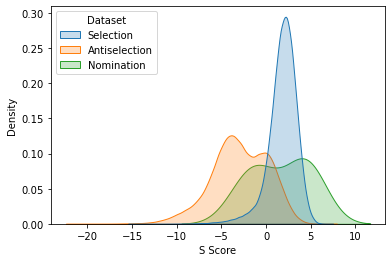

In [6]:
# CONFIG - CUSTOM SCREENING TEST

config = {
    'features': 'onehot', 
    'model': 'MLP', 
    'learning_rate': 0.01, 
    'routine': 'screen', 
    'ckpt': 'checkpoints/NNK7_rd3_epoch=33_val_accuracy=0.92.ckpt', 
    'variable_region': [14, 15, 16, 17, 18, 19, 20, 21], 
    'variable_length': 8, 
    'filter_seq': None, 
    'hamming': -1, 
    'thresh': 0.97, 
    'sele': '/proj/kuhl_lab/users/dieckhau/LynD-substrate-modeling/LynD-substrate-modeling/data/csv/NNK7/rd3/sele', 
    'anti': '/proj/kuhl_lab/users/dieckhau/LynD-substrate-modeling/LynD-substrate-modeling/data/csv/NNK7/rd3/anti', 
    'seed': 1234, 
    'include_C': True, 
    'activity': 'high'
}

args = argparse.Namespace(**config)

from trainer import SequenceModelPL
from dataset import LibraryDataset
from torch.utils.data import DataLoader

def screen_custom(args):

    # make custom peptide set

    # retrieve model and run predictions
    model = SequenceModelPL.load_from_checkpoint(args.ckpt, args=args).model
    model = model.to('cuda')
    model.eval()

    # define custom peptides to test
    library = [
        'ACMSGSGS',
        'SACMSGSG',
        'GSACMSGS',
        'SGSACMSG', 
        'GSGSACMS', 
        'SGSGSACM'
    ]

    tags = [
        'pep3', 
        'pep4', 
        'pep5', 
        'pep6', 
        'pep7', 
        'pep8'
    ]
        
    library = [list(word) for word in library]
    library = np.array(library)

    pred_list = []
    # screen custom dataset    
    ds = LibraryDataset(library, features=args.features)
    loader = DataLoader(ds, num_workers=8, shuffle=False, batch_size=1024)
    for batch in tqdm(loader):
        batch = batch.to('cuda') 
        preds = model(batch)
        preds = torch.squeeze(preds, -1)
        pred_list.append(preds) 
    pred_list = torch.cat(pred_list, dim=0).to('cpu').detach().numpy()
    print(pred_list)

    library = [''.join(li) for li in library]
    
    df = pd.DataFrame({
        'SEQ': library, 
        'MODEL_SCORE': pred_list
    })
    
    # S-score calculation
    ref = hamming(args, library, pred_list)
    ref_df = ref.df
    sel_df = ref_df.loc[ref_df['active'] == 1]
    anti_df = ref_df.loc[ref_df['active'] == 0]
    
    y_star = y_star_score(sel_df, anti_df)
    sel_s = s_score(sel_df, y_star)
    anti_s = s_score(anti_df, y_star)
    
    df['var_seq'] = df.SEQ
    pep_s = s_score(df, y_star)

    # visualize S scores
    disp = pd.concat([
        pd.DataFrame({'Dataset': 'Selection', 'S Score': sel_s}), 
        pd.DataFrame({'Dataset': 'Antiselection', 'S Score': anti_s}),
        pd.DataFrame({'Dataset': 'Nomination', 'S Score': pep_s})
                      
    ])
    disp = disp.reset_index(drop=True)
    
    ax = sns.kdeplot(data=disp, x='S Score', hue='Dataset', common_norm=False, fill=True)
    sns.move_legend(ax, 'upper left')
    
    # convert S Scores to percentiles for better interpretability (0 to 1)
    s_total = np.concatenate([sel_s, anti_s])
    pep_s_perc = [(p > s_total).sum() / s_total.size for p in pep_s]
    
    # save df to output
    df['S_SCORE'] = pep_s
    df['S_SCORE_PERCENTILE'] = pep_s_perc
    df['TAG'] = tags
    df.to_csv('NNK7_DistanceDependence.csv')
    
    return df

df = screen_custom(args)


# Peptide Set 3 - C6 Peptides

In [ ]:
# CONFIG - Peptide set 3 (C6Range)

config = {
    'features': 'onehot', 
    'model': 'MLP', 
    'learning_rate': 0.01, 
    'routine': 'screen', 
    'ckpt': 'checkpoints/NNK7_rd3_epoch=33_val_accuracy=0.92.ckpt', 
    'variable_region': [14, 15, 16, 17, 18, 19, 20, 21], 
    'variable_length': 8, 
    'filter_seq': 'C6', 
    'hamming': 2, 
    'thresh': 0.03, 
    'sele': '/proj/kuhl_lab/users/dieckhau/LynD-substrate-modeling/LynD-substrate-modeling/data/csv/NNK7/rd3/sele', 
    'anti': '/proj/kuhl_lab/users/dieckhau/LynD-substrate-modeling/LynD-substrate-modeling/data/csv/NNK7/rd3/anti', 
    'seed': 1234, 
    'include_C': True, 
    'activity': 'low'
}

args = argparse.Namespace(**config)

from trainer import SequenceModelPL
from dataset import LibraryDataset
from torch.utils.data import DataLoader

def nominate_C6Range(args):

    # generate 1M peptides with high predicted activity
    library, pred_list = screen_routine(args, N=1000000, thresh=args.thresh, H=args.hamming, save=False, length=args.variable_length, filter=args.filter_seq)    

    library, pred_list = select_C6_only(library, pred_list)

    # keep only mid-range values (0.1 to 0.9)
    # library_keep, pred_keep = [], []
    # for li, pr, in zip(library, pred_list):
    #     if (pr > 0.1) and (pr < 0.9):
    #         library_keep.append(li)
    #         pred_keep.append(pr)
    # library = library_keep
    # pred_list = pred_keep
    
    # S-score calculation
    df, ref = hamming(args, library, pred_list)
    ref_df = ref.df
    sel_df = ref_df.loc[ref_df['active'] == 1]
    anti_df = ref_df.loc[ref_df['active'] == 0]
    
    y_star = y_star_score(sel_df, anti_df)
    sel_s = s_score(sel_df, y_star)
    anti_s = s_score(anti_df, y_star)
    
    df['var_seq'] = df.SEQ
    pep_s = s_score(df, y_star)

    # visualize S scores
    disp = pd.concat([
        pd.DataFrame({'Dataset': 'Selection', 'S Score': sel_s}), 
        pd.DataFrame({'Dataset': 'Antiselection', 'S Score': anti_s}),
        pd.DataFrame({'Dataset': 'Nomination', 'S Score': pep_s})
                      
    ])
    disp = disp.reset_index(drop=True)
    
    ax = sns.kdeplot(data=disp, x='S Score', hue='Dataset', common_norm=False, fill=True)
    sns.move_legend(ax, 'upper left')
    
    # convert S Scores to percentiles for better interpretability (0 to 1)
    s_total = np.concatenate([sel_s, anti_s])
    pep_s_perc = [(p > s_total).sum() / s_total.size for p in pep_s]
    
    # save df to output
    df['S_SCORE'] = pep_s
    df['S_SCORE_PERCENTILE'] = pep_s_perc
    df.to_csv('NNK7_C6Range.csv')
    
    return df

df = nominate_C6Range(args)
